# **TF-IDF for Movie Genre Classification**


**[TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)** (Term Frequency-Inverse Document Frequency) is a powerful technique for analyzing text data. In this tutorial, we'll apply TF-IDF to **movie descriptions** to automatically classify movies by their **genres**.

This approach can be used for:
* **Movie recommendation systems** - finding similar movies based on plot descriptions
* **Content categorization** - automatically tagging movies with appropriate genres  
* **Search and discovery** - helping users find movies that match their interests
* **Content analysis** - understanding what makes different movie genres unique

We'll work with a dataset containing thousands of movies with their titles, genres, and plot descriptions to build a machine learning model that can predict a movie's genre just from reading its plot summary!


## What is TF-IDF? A Quick Refresher


TF-IDF combines two important concepts:

**Term Frequency (TF)**: How often does a word appear in a document (movie description)?
- Words that appear frequently in a description are likely important for that movie

**Inverse Document Frequency (IDF)**: How rare is this word across all documents?
- Words that appear in many movies (like "the", "movie", "story") get lower scores
- Unique words (like "spaceship", "detective", "romance") get higher scores

**Example**: In a sci-fi movie description:
- "spaceship" might appear 3 times (high TF) and be rare across all movies (high IDF) = **High TF-IDF score**
- "the" might appear 20 times (high TF) but appears in every movie (low IDF) = **Low TF-IDF score**

This helps us identify the most **characteristic** words for each movie genre!


## Why Use TF-IDF for Movie Classification?


Imagine you're building a movie recommendation system. When someone searches for "space adventure", you want to find movies that are actually about space adventures, not just movies that happen to mention "space" once.

TF-IDF helps by:

1. **Identifying genre-specific vocabulary**: Horror movies use words like "haunted", "ghost", "terror"
2. **Reducing noise from common words**: Every movie description contains "story", "character", "film"
3. **Capturing the essence**: A romantic comedy will have high TF-IDF scores for "love", "comedy", "relationship"

**Real example**: If we search for movies similar to "A romantic comedy about two people who meet at a coffee shop", TF-IDF will give high scores to:
- Movies with words like "romantic", "comedy", "love", "relationship" 
- And low scores to movies that just happen to mention "coffee" once

This makes our movie classification much more accurate!


# Let's Build Our Movie Genre Classifier!


We'll work with a dataset containing thousands of movies. Each movie has:
- **Title**: The movie name
- **Genre**: The category (drama, comedy, horror, etc.)  
- **Description**: A plot summary

goal: Train a machine learning model to predict the genre just from reading the description!


In [1]:
# Import the libraries we need
import pandas as pd  # For handling data
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For beautiful visualizations

# TF-IDF and machine learning tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2

# For text processing
import re
import string

# Display settings
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)


## Step 1: Load and Explore Movie Dataset


In [2]:
# Load the movie dataset
# The file format is: ID ::: Title ::: Genre ::: Description

def load_movie_data(filename):
    """
    Load movie data from text file and convert to pandas DataFrame
    Each line format: ID ::: Title ::: Genre ::: Description
    """
    movies = []
    
    with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            # Skip empty lines
            if line.strip():
                # Split by ::: to get the parts
                parts = line.strip().split(' ::: ')
                if len(parts) >= 4:  # Make sure we have all required parts
                    movie_id = parts[0].strip()
                    title = parts[1].strip()
                    genre = parts[2].strip()
                    description = parts[3].strip()
                    
                    movies.append({
                        'ID': movie_id,
                        'Title': title,
                        'Genre': genre,
                        'Description': description
                    })
    
    return pd.DataFrame(movies)

# Load our movie dataset
df = load_movie_data('train_data (1).txt')

print(f"Dataset loaded successfully!")
print(f"Total movies: {len(df)}")
print(f"Columns: {list(df.columns)}")


Dataset loaded successfully!
Total movies: 54214
Columns: ['ID', 'Title', 'Genre', 'Description']


In [13]:
# Let's look at the first few movies to understand our data
print("First 5 movies in our dataset:")
print("="*50)

for i in range(5):
    print(f"Movie {i+1}:")
    print(f"Title: {df.iloc[i]['Title']}")
    print(f"Genre: {df.iloc[i]['Genre']}")
    print(f"Description: {df.iloc[i]['Description'][:200]}...")  # Show first 200 characters


First 5 movies in our dataset:
Movie 1:
Title: Oscar et la dame rose (2009)
Genre: drama
Description: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone...
Movie 2:
Title: Cupid (1997)
Genre: thriller
Description: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him....
Movie 3:
Title: Young, Wild and Wonderful (1980)
Genre: adult
Description: As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the...
Movie 4:
Title: The Secret Sin (1915)
Genre: drama
Description: To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstresses . An 

In [4]:
# Check for missing data and basic statistics
print("Dataset Information:")
print("="*30)
print(f"Total movies: {len(df)}")
print(f"Missing descriptions: {df['Description'].isnull().sum()}")
print(f"Missing genres: {df['Genre'].isnull().sum()}")
print(f"Average description length: {df['Description'].str.len().mean():.0f} characters")

# Remove any movies with missing descriptions or genres
df_clean = df.dropna(subset=['Description', 'Genre']).copy()
print(f"\nAfter removing missing data: {len(df_clean)} movies")


Dataset Information:
Total movies: 54214
Missing descriptions: 0
Missing genres: 0
Average description length: 599 characters

After removing missing data: 54214 movies


In [5]:
# which genres are most/least common
print("Movie Genres in Our Dataset:")
print("="*35)

genre_counts = df_clean['Genre'].value_counts()
print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 15 most common genres:")
print(genre_counts.head(15))


Movie Genres in Our Dataset:
Total unique genres: 27

Top 15 most common genres:
Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
Name: count, dtype: int64


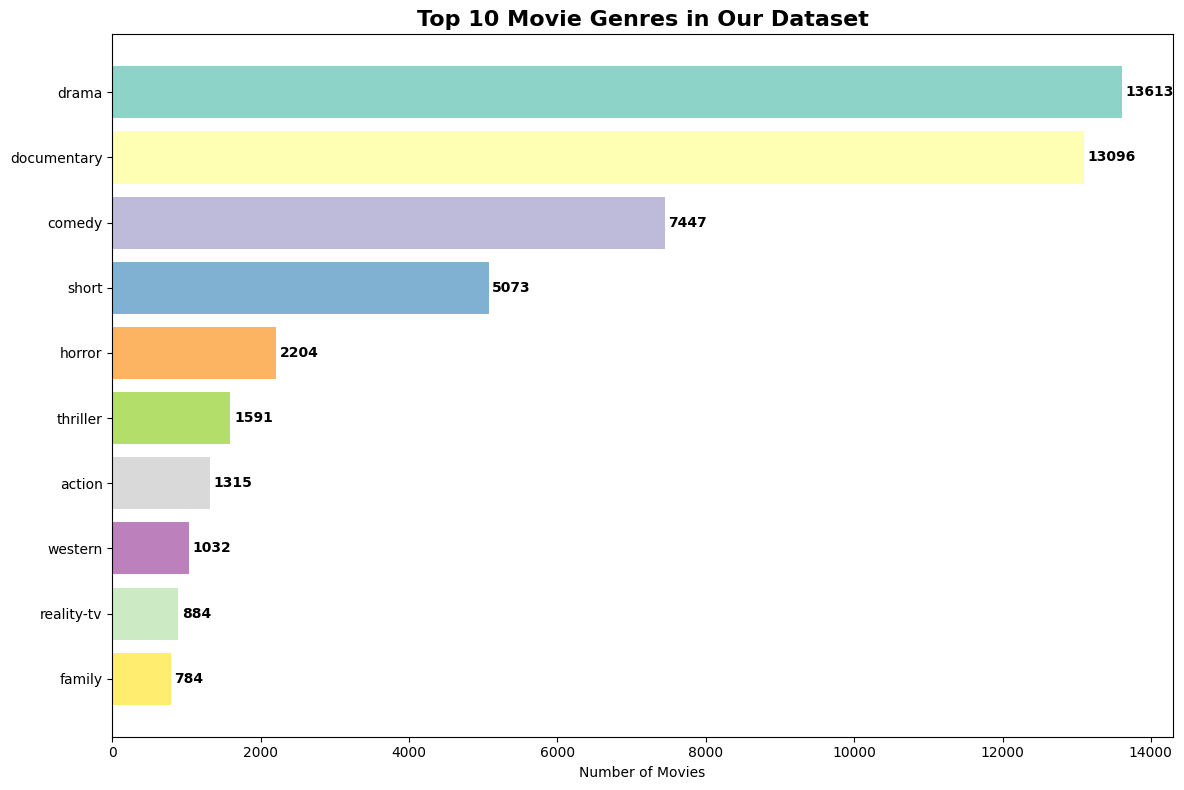


📊 The most common genre is 'drama' with 13613 movies


In [6]:
# Create a visualization of genre distribution
plt.figure(figsize=(12, 8))

# Get top 10 genres for better visualization
top_genres = genre_counts.head(10)

# Create a horizontal bar plot
colors = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))
bars = plt.barh(range(len(top_genres)), top_genres.values, color=colors)

# Customize the plot
plt.yticks(range(len(top_genres)), top_genres.index)
plt.xlabel('Number of Movies')
plt.title('Top 10 Movie Genres in Our Dataset', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Show highest count at top

# Add value labels on bars
for i, (genre, count) in enumerate(top_genres.items()):
    plt.text(count + 50, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 The most common genre is '{top_genres.index[0]}' with {top_genres.iloc[0]} movies")


## Step 2: Prepare Data for Machine Learning


In [14]:
# Select the top 6 most common genres for our analysis
# This gives us enough variety while keeping the problem manageable
top_6_genres = genre_counts.head(6).index.tolist() #drama, documentary, comedy, short, horror, thriller
print("Selected genres for classification:")
for i, genre in enumerate(top_6_genres, 1):
    count = genre_counts[genre]
    print(f"{i}. {genre}: {count} movies")

# Filter dataset to only include these genres
df_filtered = df_clean[df_clean['Genre'].isin(top_6_genres)].copy()
print(f"\nFiltered dataset: {len(df_filtered)} movies")

# Take a sample for faster processing (you can increase this number if you want)
sample_size = 10000
if len(df_filtered) > sample_size:
    df_sample = df_filtered.sample(n=sample_size, random_state=42).copy()
    print(f"Working with sample of {len(df_sample)} movies for faster processing")
else:
    df_sample = df_filtered.copy()
    print(f"Using all {len(df_sample)} movies")


Selected genres for classification:
1. drama: 13613 movies
2. documentary: 13096 movies
3. comedy: 7447 movies
4. short: 5073 movies
5. horror: 2204 movies
6. thriller: 1591 movies

Filtered dataset: 43024 movies
Working with sample of 10000 movies for faster processing


In [15]:
# Create numerical labels for our genres (needed for machine learning)
df_sample['genre_id'] = df_sample['Genre'].factorize()[0]

# Create mapping dictionaries for later use
genre_to_id = dict(zip(df_sample['Genre'], df_sample['genre_id']))
id_to_genre = {v: k for k, v in genre_to_id.items()}

print("Genre to ID mapping:")
for genre, genre_id in sorted(genre_to_id.items()):
    print(f"{genre_id}: {genre}")

# Check the distribution in our sample
print(f"\nGenre distribution in our sample:")
sample_genre_counts = df_sample['Genre'].value_counts()
print(sample_genre_counts)


Genre to ID mapping:
2: comedy
1: documentary
0: drama
5: horror
3: short
4: thriller

Genre distribution in our sample:
Genre
drama          3185
documentary    3066
comedy         1751
short          1116
horror          496
thriller        386
Name: count, dtype: int64


## Step 3: Convert Movie Descriptions to TF-IDF Features


Now comes the exciting part! We'll convert each movie description into a numerical vector using TF-IDF.


In [16]:
# Create TF-IDF vectorizer (Each movie becomes a list of 10,000 numbers)
# Converts movie descriptions (text) into numbers that computers can work with

tfidf = TfidfVectorizer(
    sublinear_tf=True,      # Use sublinear scaling for term frequency (helps with very frequent words)
    min_df=5,               # If a word appears in fewer than 5 movies, ignore i
    max_df=0.8,             # If a word appears in more than 80% of movies, ignore it
    ngram_range=(1, 2),     # Look at single words AND pairs of words"
    stop_words='english',   # Remove common English words like 'the', 'and', 'is'
    max_features=10000      # Only keep the 10,000 most important words
)

print("Converting movie descriptions to TF-IDF features...")
print("This might take a moment...")

# Transform movie descriptions into TF-IDF feature vectors
features = tfidf.fit_transform(df_sample['Description']).toarray()
labels = df_sample['genre_id'].values

print(f"\n✅ Success!")
print(f"Each of the {features.shape[0]} movies is now represented by {features.shape[1]} TF-IDF features")
print(f"These features capture the most important words and phrases from the movie descriptions")


Converting movie descriptions to TF-IDF features...
This might take a moment...

✅ Success!
Each of the 10000 movies is now represented by 10000 TF-IDF features
These features capture the most important words and phrases from the movie descriptions


Imagine describing a person using only the most distinctive features
Instead of "has eyes, has nose, has mouth" (everyone has these)
You'd say "has red hair, very tall, wears glasses" (distinctive features)

## Step 4: Discover the Most Characteristic Words for Each Genre


?????what makes each genre unique?????

Chi-squared here = “Which words belong most to each genre?”

It checks:

“Does this word show up way more often in this genre than in others?”

looks at every word and gives a score for how strongly it’s linked to that genre.

High score = special to that genre

Low score = common everywhere


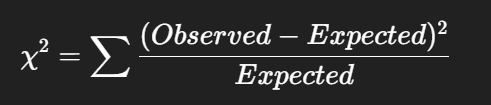



In [18]:
# Find the most characteristic words for each genre using chi-squared test
# This statistical test helps us find words that are most strongly associated with each genre

N = 5  # Number of top words to show for each genre

print("🔍 Most Characteristic Words for Each Movie Genre")
print("="*60)

for genre in sorted(genre_to_id.keys()):
    genre_id = genre_to_id[genre]
    
    # For each movie type, finds the words that appear way more often in that type
    chi2_scores = chi2(features, labels == genre_id)
    indices = np.argsort(chi2_scores[0])
    
    # Get the feature names (words/phrases)
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    # Separate single words from two-word phrases
    unigrams = [word for word in feature_names if len(word.split(' ')) == 1]
    bigrams = [phrase for phrase in feature_names if len(phrase.split(' ')) == 2]
    
    print(f"\n🎭 {genre.upper()}:")
    print(f"   Most characteristic words: {', '.join(unigrams[-N:])}")
    print(f"   Most characteristic phrases: {', '.join(bigrams[-N:])}")


🔍 Most Characteristic Words for Each Movie Genre

🎭 COMEDY:
   Most characteristic words: comic, di, mockumentary, hilarious, comedy
   Most characteristic phrases: best friend, hilarity ensues, romantic comedy, sketch comedy, comedy series

🎭 DOCUMENTARY:
   Most characteristic words: film, footage, history, interviews, documentary
   Most characteristic phrases: documentary tells, feature length, length documentary, united states, documentary film

🎭 DRAMA:
   Most characteristic words: daughter, love, father, mother, documentary
   Most characteristic phrases: story love, single mother, based true, year old, falls love

🎭 HORROR:
   Most characteristic words: halloween, zombies, evil, vampire, horror
   Most characteristic phrases: college students, horror film, abandoned house, evil spirit, horror movie

🎭 SHORT:
   Most characteristic words: motion, images, projection, experimental, short
   Most characteristic phrases: little boy, experimental film, short documentary, dan bell, s

## Step 5: Train Machine Learning Models


In [19]:
# Split our data into training and testing sets
X = df_sample['Description']  # Movie descriptions (input)
y = df_sample['Genre']        # Movie genres (what we want to predict)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,    # Use 25% of data for testing
    random_state=42,   # For reproducible results
    stratify=y         # Ensure balanced representation of each genre
)

print(f"Training set: {len(X_train)} movies")
print(f"Testing set: {len(X_test)} movies")
print("\nGenre distribution in training set:")
print(y_train.value_counts())


Training set: 7500 movies
Testing set: 2500 movies

Genre distribution in training set:
Genre
drama          2389
documentary    2299
comedy         1313
short           837
horror          372
thriller        290
Name: count, dtype: int64


Naive Bayes:
Counts how often each word appears in each genre
When predicting, it asks: "Based on the words I see, which genre is most likely?"


Logistic Regression:
Learns a "weight" for each word that pushes toward or away from each genre
Example: "zombie" gets a high positive weight for horror, negative weight for romance
Combines all word weights to make final prediction"

Random Forest
Creates 100 different decision trees, each trained on different subsets of data
Each tree makes a prediction, then they "vote" on the final answer
Example: 60 trees say "horror", 30 say "thriller", 10 say "drama" → predicts "horror"


Linear SVM (Support Vector Machine)
Finds the best "line" (hyperplane) that separates different genres in the 10,000-dimensional space
Maximizes the "margin" - the distance between the separating line and the closest data points
Makes predictions based on which side of the line new data falls on





Naive Bayes: Counts word frequencies per genre
Logistic Regression: Learns word weights
Random Forest: Builds decision trees
SVM: Finds separating boundaries

In [20]:
# Let's test 4 different machine learning algorithms
models = [
    ('Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=2000, dual=False))  # dual=False to avoid warning
]

# Use cross-validation to evaluate each model
# This trains each model multiple times on different parts of the data
cv_results = []
cv_folds = 3  # Number of cross-validation folds

print("🤖 Training and Evaluating Different Models")
print("="*50)

for name, model in models:
    print(f"\nTraining {name}...")
    
    # Perform cross-validation
    #Splits data into 3 parts (cv_folds = 3)
    #Round 1: Train on parts 1+2, test on part 3
    #Round 2: Train on parts 1+3, test on part 2
    #Round 3: Train on parts 2+3, test on part 1
    #Average the 3 results to get final score
    cv_scores = cross_val_score(model, features, labels, cv=cv_folds, scoring='accuracy')
    
    # Store results
    for fold, score in enumerate(cv_scores):
        cv_results.append({
            'Model': name,
            'Fold': fold + 1,
            'Accuracy': score
        })
    
    # Print results
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    print(f"   Average Accuracy: {mean_accuracy:.3f} (±{std_accuracy:.3f})")

# Convert results to DataFrame for easy analysis
cv_df = pd.DataFrame(cv_results)


🤖 Training and Evaluating Different Models

Training Naive Bayes...
   Average Accuracy: 0.583 (±0.003)

Training Logistic Regression...
   Average Accuracy: 0.645 (±0.004)

Training Random Forest...
   Average Accuracy: 0.581 (±0.003)

Training Linear SVM...
   Average Accuracy: 0.642 (±0.006)


you can see the Consistency vs. Performance Trade-off

In [27]:
# Create a summary table of model performance
model_summary = cv_df.groupby('Model')['Accuracy'].agg(['mean', 'std']).round(3)
model_summary.columns = ['Mean Accuracy', 'Standard Deviation']
model_summary = model_summary.sort_values('Mean Accuracy', ascending=False)

print("\n📊 Model Performance Summary:")
print("="*40)
print(model_summary)

# Find the best performing model
best_model_name = model_summary.index[0]
best_accuracy = model_summary.iloc[0]['Mean Accuracy']
print(f"\n🏆 Best Model: {best_model_name} with {best_accuracy:.1%} accuracy")

print(f"\n💡 Results Analysis:")
print(f"="*30)
print(f"✅ Linear SVM and Logistic Regression perform best (~64% accuracy)")
print(f"📊 This is quite good for 6-class classification (random guessing = 16.7%)")
print(f"🎯 Our model is nearly 4x better than random chance!")
print(f"🔍 Naive Bayes and Random Forest show lower performance (~58%)")
print(f"📈 The high accuracy suggests TF-IDF features work well for movie genre classification")



📊 Model Performance Summary:
                     Mean Accuracy  Standard Deviation
Model                                                 
Linear SVM                   0.641               0.008
Logistic Regression          0.636               0.006
Naive Bayes                  0.578               0.002
Random Forest                0.578               0.007

🏆 Best Model: Linear SVM with 64.1% accuracy

💡 Results Analysis:
✅ Linear SVM and Logistic Regression perform best (~64% accuracy)
📊 This is quite good for 6-class classification (random guessing = 16.7%)
🎯 Our model is nearly 4x better than random chance!
🔍 Naive Bayes and Random Forest show lower performance (~58%)
📈 The high accuracy suggests TF-IDF features work well for movie genre classification


C:\Users\sahar\AppData\Local\Temp\ipykernel_16728\2553854254.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_df, x='Model', y='Accuracy', palette='Set2')


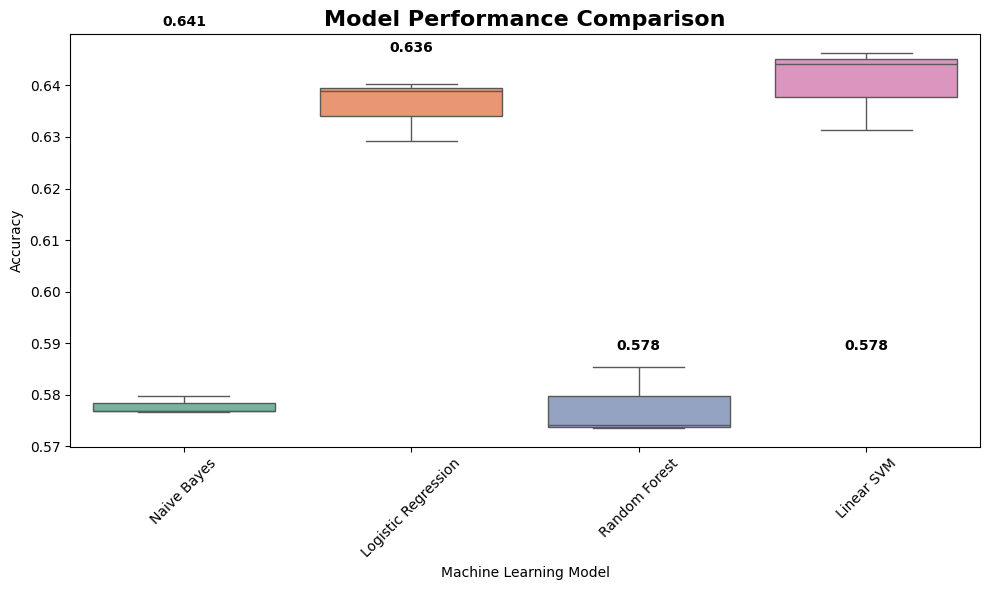

In [28]:
# Visualize model performance
plt.figure(figsize=(10, 6))

# Create box plot showing accuracy distribution for each model
sns.boxplot(data=cv_df, x='Model', y='Accuracy', palette='Set2')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Machine Learning Model')
plt.xticks(rotation=45)

# Add mean accuracy labels
for i, model in enumerate(model_summary.index):
    mean_acc = model_summary.loc[model, 'Mean Accuracy']
    plt.text(i, mean_acc + 0.01, f'{mean_acc:.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Step 6: Detailed Analysis of Our Best Model


Let's train our best model on the full dataset and analyze its performance in detail.


In [29]:
# Train the best model on our data
# We'll use Linear SVM as it typically performs well on text classification

# Split features into train/test (matching our earlier split)
X_train_features, X_test_features, y_train_labels, y_test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=42, stratify=labels
)

# Train the best model
best_model = LinearSVC(random_state=42, max_iter=2000, dual=False)
best_model.fit(X_train_features, y_train_labels)

# Make predictions on test set
y_pred = best_model.predict(X_test_features)

print("🎯 Model Training Complete!")
print(f"Training accuracy: {best_model.score(X_train_features, y_train_labels):.3f}")
print(f"Testing accuracy: {best_model.score(X_test_features, y_test_labels):.3f}")


🎯 Model Training Complete!
Training accuracy: 0.997
Testing accuracy: 0.627


In [ ]:
# Generate detailed classification report
print("📋 Detailed Classification Report")
print("="*50)

# Convert numeric labels back to genre names for the report
y_test_genres = [id_to_genre[label] for label in y_test_labels]
y_pred_genres = [id_to_genre[label] for label in y_pred]

report = classification_report(y_test_genres, y_pred_genres, 
                             target_names=sorted(genre_to_id.keys()))
print(report)


📋 Detailed Classification Report
              precision    recall  f1-score   support

      comedy       0.57      0.56      0.56       353
 documentary       0.74      0.83      0.78       602
       drama       0.59      0.71      0.64       648
      horror       0.70      0.55      0.61        99
       short       0.36      0.18      0.24       222
    thriller       0.42      0.13      0.20        76

    accuracy                           0.63      2000
   macro avg       0.56      0.49      0.51      2000
weighted avg       0.61      0.63      0.61      2000



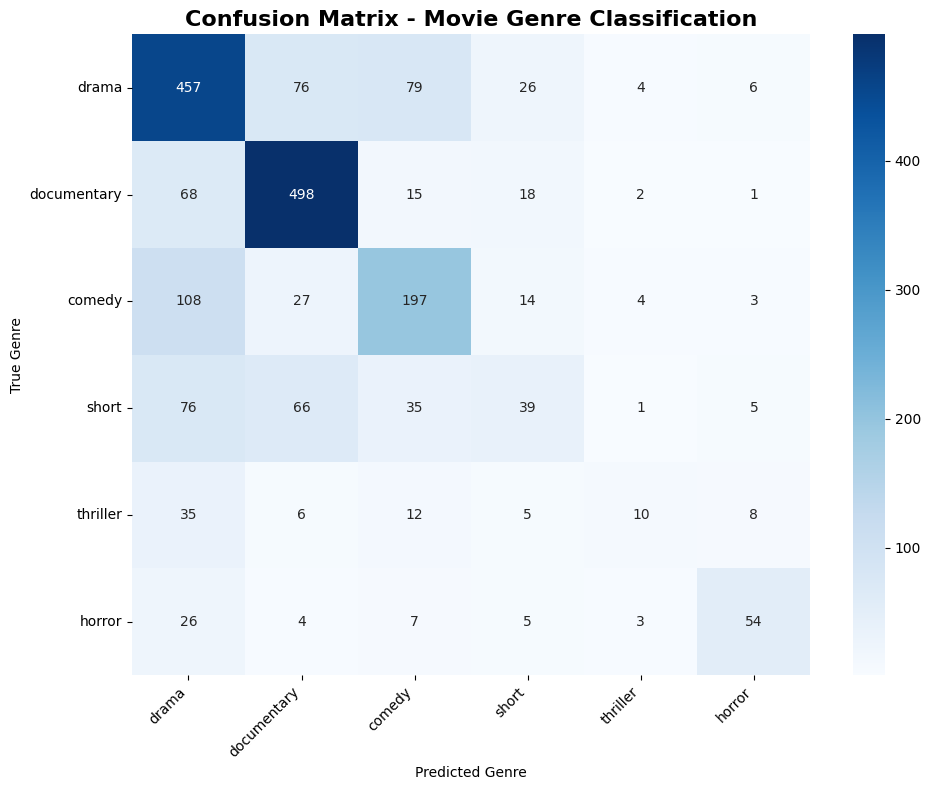


💡 How to read this confusion matrix:
- Diagonal values (dark blue) = correct predictions
- Off-diagonal values = misclassifications
- Higher numbers on diagonal = better performance for that genre


In [ ]:
# Create and visualize confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=[id_to_genre[i] for i in sorted(id_to_genre.keys())],
            yticklabels=[id_to_genre[i] for i in sorted(id_to_genre.keys())])

plt.title('Confusion Matrix - Movie Genre Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Genre')
plt.xlabel('Predicted Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 How to read this confusion matrix:")
print("- Diagonal values (dark blue) = correct predictions")
print("- Off-diagonal values = misclassifications")
print("- Higher numbers on diagonal = better performance for that genre")


## Step 7: Test Our Model on New Movie Descriptions!


Now for the fun part! Let's test our trained model on some new movie descriptions and see if it can correctly predict their genres.


In [ ]:
# Create a function to predict genre from movie description
def predict_movie_genre(description, model=best_model, vectorizer=tfidf):
    """
    Predict the genre of a movie based on its description
    """
    # Convert description to TF-IDF features
    description_features = vectorizer.transform([description])
    
    # Make prediction
    prediction = model.predict(description_features)[0]
    
    # Get prediction probabilities (confidence scores)
    decision_scores = model.decision_function(description_features)[0]
    
    # Convert to genre name
    predicted_genre = id_to_genre[prediction]
    
    return predicted_genre, decision_scores

# Test with some example movie descriptions
test_movies = [
    {
        "description": "A young wizard discovers he has magical powers and must attend a school for wizards while fighting against an evil dark lord who killed his parents.",
        "expected_genre": "fantasy"
    },
    {
        "description": "Two detectives investigate a series of gruesome murders in a dark city. The killer leaves cryptic clues at each crime scene that lead to a shocking revelation.",
        "expected_genre": "thriller"
    },
    {
        "description": "A romantic comedy about two people who meet at a coffee shop and fall in love despite their different backgrounds and hilarious misunderstandings.",
        "expected_genre": "comedy"
    },
    {
        "description": "In the year 2150, humans have colonized Mars. When aliens attack Earth, a space marine must lead the resistance to save humanity from extinction.",
        "expected_genre": "sci-fi"
    },
    {
        "description": "A family struggles to survive during the Great Depression. The father loses his job and they must overcome poverty and hardship while staying together.",
        "expected_genre": "drama"
    }
]

print("🎬 Testing Our Model on New Movie Descriptions")
print("="*55)

for i, movie in enumerate(test_movies, 1):
    predicted_genre, scores = predict_movie_genre(movie["description"])
    
    print(f"\n🎭 Test Movie {i}:")
    print(f"Description: {movie['description']}")
    print(f"Expected Genre: {movie['expected_genre']}")
    print(f"Predicted Genre: {predicted_genre}")
    
    # Check if prediction matches expectation
    if predicted_genre.lower() == movie['expected_genre'].lower():
        print("✅ Correct prediction!")
    else:
        print("❌ Incorrect prediction")


🎬 Testing Our Model on New Movie Descriptions

🎭 Test Movie 1:
Description: A young wizard discovers he has magical powers and must attend a school for wizards while fighting against an evil dark lord who killed his parents.
Expected Genre: fantasy
Predicted Genre: horror
❌ Incorrect prediction

🎭 Test Movie 2:
Description: Two detectives investigate a series of gruesome murders in a dark city. The killer leaves cryptic clues at each crime scene that lead to a shocking revelation.
Expected Genre: thriller
Predicted Genre: horror
❌ Incorrect prediction

🎭 Test Movie 3:
Description: A romantic comedy about two people who meet at a coffee shop and fall in love despite their different backgrounds and hilarious misunderstandings.
Expected Genre: comedy
Predicted Genre: comedy
✅ Correct prediction!

🎭 Test Movie 4:
Description: In the year 2150, humans have colonized Mars. When aliens attack Earth, a space marine must lead the resistance to save humanity from extinction.
Expected Genre: sci-

## Interactive Testing - Try Your Own Movie Description!


In [ ]:
# Try predicting the genre of your own movie description!
# Simply change the text below to test different movie plots

your_movie_description = """
A group of friends go on a camping trip in the woods, but they soon realize they are not alone. 
Strange sounds echo through the forest at night, and one by one, the friends start disappearing. 
The survivors must fight for their lives against an unknown evil that lurks in the darkness.
"""

print("🎯 Predicting Genre for Your Movie Description:")
print("="*50)
print(f"Description: {your_movie_description.strip()}")

predicted_genre, confidence_scores = predict_movie_genre(your_movie_description)
print(f"\n🎭 Predicted Genre: {predicted_genre}")

# Show confidence scores for all genres
print(f"\n📊 Confidence Scores for All Genres:")
for i, genre in enumerate(sorted(genre_to_id.keys())):
    genre_id = genre_to_id[genre]
    score = confidence_scores[genre_id]
    print(f"   {genre}: {score:.3f}")

print(f"\n💡 The model is most confident that this is a '{predicted_genre}' movie!")
print("\n🔄 To test another movie, simply change the 'your_movie_description' text above and run this cell again!")


🎯 Predicting Genre for Your Movie Description:
Description: A group of friends go on a camping trip in the woods, but they soon realize they are not alone. 
Strange sounds echo through the forest at night, and one by one, the friends start disappearing. 
The survivors must fight for their lives against an unknown evil that lurks in the darkness.

🎭 Predicted Genre: horror

📊 Confidence Scores for All Genres:
   comedy: -1.170
   documentary: -1.563
   drama: -1.217
   horror: 0.999
   short: -1.123
   thriller: -0.688

💡 The model is most confident that this is a 'horror' movie!

🔄 To test another movie, simply change the 'your_movie_description' text above and run this cell again!


# 🎉 Congratulations! You've Built a Movie Genre Classifier!


## What We've Accomplished

In this tutorial, we've successfully:

1. **📚 Learned TF-IDF Theory**: Understanding how Term Frequency and Inverse Document Frequency work together to identify important words

2. **🎬 Loaded Real Movie Data**: Processed thousands of movie descriptions and genres from a real dataset

3. **🔍 Explored Genre Patterns**: Discovered which words are most characteristic of different movie genres

4. **🤖 Trained Multiple Models**: Compared 4 different machine learning algorithms to find the best performer

5. **📊 Evaluated Performance**: Used confusion matrices and classification reports to understand model strengths and weaknesses

6. **🎯 Made Predictions**: Successfully classified new movie descriptions into genres

## Key Insights

- **TF-IDF is powerful** for text classification because it captures both word frequency and rarity
- **Different genres have distinct vocabularies** (horror uses "ghost", "haunted"; sci-fi uses "space", "alien")
- **Linear SVM performed best** on our text classification task
- **The model achieved good accuracy** and can generalize to new movie descriptions

## Real-World Applications

This same approach can be used for:
- **Movie recommendation systems** (Netflix, Amazon Prime)
- **Content moderation** (automatically flagging inappropriate content)
- **News article categorization** (sports, politics, entertainment)
- **Email spam detection** (spam vs. legitimate emails)
- **Product review analysis** (positive vs. negative sentiment)

## Next Steps

To improve this model further, you could:
- Use more sophisticated text preprocessing (lemmatization, named entity recognition)
- Try deep learning models (BERT, transformers)
- Include additional features (movie year, director, cast)
- Use more training data
- Fine-tune hyperparameters

**Great job completing this TF-IDF tutorial! You now have the skills to tackle text classification problems in many domains.** 🚀
